### Домашнее задание Transformers Training (50 баллов)

В этом домашнем задании требуется обучить несколько Transformer-based моделей в задаче машинного перевода. Для обучения можно воспользоваться текущим проектом, так и реализовать свой пайплайн обучения. Если будете использовать проект, теги **TODO** проекта отмечают, какие компоненты надо реализовать.
В ноутбуке нужно только отобразить результаты обучения и выводы. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Ваш код обучения нужно выложить на ваш github, в строке ниже дать ссылку на него. В первую очередь будут оцениваться результаты в ноутбуке, код нужен для проверки адекватности результатов.

Обучать модели до конца не нужно, только для демонстрации, что модель обучается и рабочая - снижение val_loss, рост bleu_score.

#### Сcылка на ваш github с проектом(вставить свой) - https://github.com/traggerET/sber_3hw_dl

Ноутбук с результатами выкладывать на ваш **google диск** курса.

### Данные

`
wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip
`

Модели нужно обучить на задаче перевода с английского на русский.

In [ ]:
# !wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip

--2024-04-29 11:01:45--  https://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16305013 (16M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  15,55M  4,92MB/s    in 3,2s    

2024-04-29 11:01:49 (4,92 MB/s) - ‘rus-eng.zip’ saved [16305013/16305013]

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [ ]:
import os
import re
import numpy as np
import torch
import random

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [ ]:
import sys
sys.path.insert(1, "./src")

### Обучение Seq2seq Transformer модель(25 баллов)

Реализуйте Seq2seq Transformer. В качестве блока трансформера можно использовать https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html. В качестве токенизатора воспользуйтесь HuggingFace токенизатор для source/target языков - https://huggingface.co/docs/transformers/fast_tokenizers
В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов.

Не забудьте остальные элементы модели:
* Мы можем использовать 1 трансформер как энкодер - декодером будет выступать линейный слой.
* Обучите свой BPE токенизатор - https://huggingface.co/docs/transformers/fast_tokenizers
* Матрицу эмбеддингов токенов
* Матрицу позицонных эмбеддингов
* Линейный слой проекции в target словарь
* Функцию маскирования будущих состояний attention, так как модель авто-регрессионна
* Learning rate schedualer


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, размерность скрытого слоя, количетсво слоев
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [ ]:
import yaml
from models import trainer
from data.datamodule import DataManager
from txt_logger import TXTLogger
from models.seq2seq_transformer import Seq2SeqTransformer
from models.seq2seq_t5 import Seq2SeqT5

In [ ]:
dcfg = yaml.load(open("configs/data_config.yaml", 'r'), Loader=yaml.Loader)
dcfg

{'prefix_filter': ['he is', 'he s ', 'she is', 'she s '],
 'max_length': 15,
 'filename': 'rus.txt',
 'train_size': 0.8,
 'batch_size': 256}

In [ ]:
data_manager = DataManager(dcfg, DEVICE)
train_dataloader, val_dataloader = data_manager.prepare_data()
target_tokenizer = data_manager.target_tokenizer

Reading from file: 100%|██████████| 496059/496059 [00:02<00:00, 185680.35it/s]


In [ ]:
mcfg = yaml.load(open("configs/model_config.yaml", "r"), Loader=yaml.Loader)
mcfg

{'embedding_size': 256,
 'dim_feedforward': 256,
 'hidden_size': 256,
 'n_heads_attention': 4,
 'n_encoders': 6,
 'n_decoders': 6,
 'learning_rate': 0.0001,
 'dropout': 0.1,
 'epoch_num': 30,
 'try_one_batch': False}

In [ ]:
model_transformer = Seq2SeqTransformer(encoder_vocab_size=len(data_manager.source_tokenizer.w2i), decoder_vocab_size=len(data_manager.target_tokenizer.w2i),
    dim_feedforward=mcfg['dim_feedforward'], lr=mcfg['learning_rate'], device=DEVICE,
    target_tokenizer=target_tokenizer, T=mcfg['epoch_num'] * len(train_dataloader), positional_embedding_size=mcfg['embedding_size'],
    n_heads_attention=mcfg['n_heads_attention'], n_encoders=mcfg['n_encoders'], n_decoders=mcfg['n_decoders'],
    dropout=mcfg['dropout'],
)

logger = TXTLogger("logs")
trainer_transformer = trainer.Trainer(model=model_transformer, model_config=mcfg, logger=logger)

if mcfg['try_one_batch']:
    train_dataloader = [list(train_dataloader)[0]]
    val_dataloader = [list(val_dataloader)[0]]

In [ ]:
trainer_transformer.train(train_dataloader, val_dataloader)

  3%|▎         | 1/30 [00:54<26:25, 54.66s/it]

predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  66 2673 1760   52   37   51  176  221  374   22    2]
words_actual:  ['он', 'холостяк', 'и', 'у', 'него', 'нет', 'брат']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [ 66 400  67 583  51 299 269 169   2   3   3]
words_actual:  ['он', 'всего', 'на', 'пару', 'лет', 'старше', 'меня']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  51  176  413   86  560  729 1507 2207 3928    2    3]
words_actual:  ['у', 'него', 'два', 'кота', 'один', 'белый', 'другой', 'чёрный']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  66  994  165   72  244  163 1587  133   13   38    2]
words_actual:  ['он', 'интересуется', 'пророчествами', 'майя']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [ 68 815 149 463 151 613   2   3   3   3   3]
words_actual:  ['она', 'такая', 'же', 'красивая', 'как', 'мать']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actu

  7%|▋         | 2/30 [01:51<26:02, 55.81s/it]

predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  68  689 1308   67   60 1878 2029   85  119    2    3]
words_actual:  ['она', 'связана', 'с', 'той', 'компанией']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  68  159 3799  194   89  116   46  733   68    2    3]
words_actual:  ['она', 'всегда', 'забывает', 'мой', 'номер', 'телефона']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  66  100 2020  336 1187   67 1323  392  198 2210    2]
words_actual:  ['он', 'откладывает', 'деньги', 'на', 'поездку', 'за', 'границу']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  66 1964  387  522 4561  196    8 1303    2    3    3]
words_actual:  ['он', 'знаком', 'здесь', 'со', 'многими', 'людьми']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  66 4429 4321  514   23   19 1448   32   14  109    2]
words_actual:  ['он', 'непременно', 'сдаст', 'вступительный', 'экза']
predicted:  [3 3 3 3 3 3 3 3 3 3 3

 10%|█         | 3/30 [02:47<25:07, 55.83s/it]

predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  68   74  348  501   68  348 1179    2    3    3    3]
words_actual:  ['она', 'не', 'моя', 'сестра', 'она', 'моя', 'жена']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  68   74  148 1252  954  326  235  501    2    3    3]
words_actual:  ['она', 'не', 'менее', 'красива', 'чем', 'её', 'сестра']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  66  951   54   88  439  207   40 3251   54  186    2]
words_actual:  ['он', 'работает', 'в', 'рекламном', 'деле', 'в', 'ло']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [ 172  749 1763  149  299 1408   37 3307    2    3    3]
words_actual:  ['ему', 'примерно', 'столько', 'же', 'лет', 'сколько', 'и', 'вам']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  66  185  264  429 3920    2    3    3    3    3    3]
words_actual:  ['он', 'боится', 'что', 'может', 'опоздать']
predicted:  [3 3 3 3 3 3 3 3 3 3

 13%|█▎        | 4/30 [03:37<23:17, 53.73s/it]

predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  68   23 1166  279  697   57 3340  280  380    2    3]
words_actual:  ['она', 'уедет', 'из', 'страны', 'через', 'полгода']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  66  104    9  657  141  759  451 2725 1122 4172    2]
words_actual:  ['он', 'обеспокоен', 'здоровьем', 'своих', 'родителей']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  54  323    5 1010   51   68 4385    5    4    5    2]
words_actual:  ['в', 'субботу', 'она', 'навестит', 'баб']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  66 1403  183  204  198 1574   57   32   14 1356    2]
words_actual:  ['он', 'переживает', 'за', 'результаты', 'экзаме']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  68  105  999   41   97 1197    2    3    3    3    3]
words_actual:  ['она', 'очень', 'беспокоится', 'о', 'его', 'здоровье']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted

 17%|█▋        | 5/30 [04:29<22:05, 53.00s/it]

predicted:  [66 66  2  3  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [  68  711  317   60 1450    2    3    3    3    3    3]
words_actual:  ['она', 'сидит', 'дома', 'с', 'детьми']
predicted:  [66 66  2  3  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [ 834   66 2791 1041   54 2337   96  273    2    3    3]
words_actual:  ['говорят', 'он', 'родился', 'в', 'африке']
predicted:  [66 66  2  3  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [  66  426  509  144 1519   38 2891 3008  197  106    2]
words_actual:  ['он', 'самый', 'высокий', 'человек', 'которого', 'я', 'когда', 'либо', 'виде']
predicted:  [66 66  2  3  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [  66  325   74  928 3769  432 1827  949 2891  139    2]
words_actual:  ['он', 'уже', 'не', 'тот', 'застенчивый', 'мальчик', 'каким', 'был', 'когда', 'то']
predicted:  [66 66  2  3  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [  66  105  241  148 2476   6

 20%|██        | 6/30 [05:17<20:36, 51.51s/it]

predicted:  [66 66  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [  66  729  279 3809 1742  134   70 1301 3693    2    3]
words_actual:  ['он', 'один', 'из', 'величайших', 'ученых', 'японии']
predicted:  [66 66  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [  66 2791 1041 1013 3618   94 1580   66 4572   21    2]
words_actual:  ['он', 'родился', 'во', 'франции', 'но', 'теперь', 'он', 'гражданин', 'с']
predicted:  [66 66  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [  66 1588   78  201  946 4572   94  989   54 3953    2]
words_actual:  ['он', 'британский', 'гражданин', 'но', 'живёт', 'в', 'индии']
predicted:  [66 66  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [  68 3024  186   10  392  181 1324  142  245    2    3]
words_actual:  ['она', 'держит', 'ложку', 'левой', 'рукой']
predicted:  [66 66  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [  66 3776  169   67  413  777  380   7

 23%|██▎       | 7/30 [06:06<19:19, 50.40s/it]

predicted:  [66 66  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [ 66 387 978  23 315 199 998   2   3   3   3]
words_actual:  ['он', 'здесь', 'пытается', 'устроить', 'неприятности']
predicted:  [66 66  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [  66  407   82   12 3049   37   90 1050 2620    2    3]
words_actual:  ['он', 'молод', 'наивен', 'и', 'неопытен']
predicted:  [66 66  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [  66  823 3960 4268    2    3    3    3    3    3    3]
words_actual:  ['он', 'стоит', 'перед', 'дверью']
predicted:  [66 66  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [ 66 400  67 583  51 299 269 169   2   3   3]
words_actual:  ['он', 'всего', 'на', 'пару', 'лет', 'старше', 'меня']
predicted:  [66 66  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [  68 3024  186   10  392  181 1324  142  245    2    3]
words_actual:  ['она', 'держит', 'ложку', 'левой', 'р

 27%|██▋       | 8/30 [06:53<18:07, 49.42s/it]

predicted:  [66 66  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [ 179   66  989   54 2508  322   12  687    2    3    3]
words_actual:  ['сейчас', 'он', 'живёт', 'в', 'квартире']
predicted:  [66 66  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [  68  978   82   86 2568 1763  970 1408  492 1159    2]
words_actual:  ['она', 'пытается', 'накопить', 'столько', 'денег', 'сколько', 'возможно']
predicted:  [66 66  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [  97  957  262  121  397   60 3484    2    3    3    3]
words_actual:  ['его', 'часто', 'путают', 'с', 'братом']
predicted:  [66 66  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [  68  586 2217   54 3535    2    3    3    3    3    3]
words_actual:  ['она', 'делает', 'успехи', 'в', 'английском']
predicted:  [66 66  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [  66  187 3385  674  440   54 4048    2    3    3    3]
words_actual:

 30%|███       | 9/30 [07:42<17:14, 49.26s/it]

predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66   54 1104   27  339 2232 1567    2    3    3    3]
words_actual:  ['он', 'в', 'отличной', 'физической', 'форме']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66  279 3167 1138   86  123 1052   49 1320  223    2]
words_actual:  ['он', 'из', 'тех', 'людей', 'которых', 'называ']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66  730   52  712 1772 4650    2    3    3    3    3]
words_actual:  ['он', 'привык', 'к', 'такого', 'рода', 'ситуациям']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66   74  928  432  264  122  101  255   55 2259    2]
words_actual:  ['он', 'не', 'тот', 'мальчик', 'что', 'приходил', 'сюда']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [1510  179   68  462   37   74  429  725   60 1221    2]
words_actual:  ['прямо', 'сейчас', 'она', 

 33%|███▎      | 10/30 [08:31<16:23, 49.20s/it]

predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66 2213  109   83  309  911 4039    2    3    3    3]
words_actual:  ['он', 'плохо', 'запоминает', 'имена']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66  100 1413   22   20   35   25 1042  801   21    2]
words_actual:  ['он', 'отбывает', 'трёхлетний', 'с']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  68   74 1858  571   27  346  342 3727    2    3    3]
words_actual:  ['она', 'не', 'симпатичнее', 'своей', 'матери']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [119 196 128 484  22  94 612 122 618  55   2]
words_actual:  ['ей', 'любопытно', 'кто', 'прислал']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  60  497 1185 2151 1923    2    3    3    3    3    3]
words_actual:  ['с', 'ней', 'трудно', 'иметь', 'дело']
predicted:  [66  2  2  2  3  3  3  3  3  3 

 37%|███▋      | 11/30 [09:21<15:39, 49.46s/it]

predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66  148  357  480   46  100 3252 3214   59    2    3]
words_actual:  ['он', 'менеджер', 'отдела', 'продаж']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  68  280 1336 3554   67  181   84   36   23   25    2]
words_actual:  ['она', 'полностью', 'глуха', 'на', 'левое', 'ух']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66 4395  144   60 2506   38 3785 4242    2    3    3]
words_actual:  ['он', 'последний', 'человек', 'с', 'кем', 'я', 'хочу', 'разговаривать']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [119 196 128 484  22  94 612 122 618  55   2]
words_actual:  ['ей', 'любопытно', 'кто', 'прислал']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66 4224  156  493  279 3809 1742  134   35  967    2]
words_actual:  ['он', 'считается', 'одним', 'из', 'величайши

 40%|████      | 12/30 [10:11<14:56, 49.79s/it]

predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [ 66 165 324  54 698 239  42 255 180  96   2]
words_actual:  ['он', 'против', 'расовой', 'дискри']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66  545   74 1737  700   97 4043    2    3    3    3]
words_actual:  ['он', 'больше', 'не', 'член', 'нашего', 'клуба']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [ 66 329 562 259 304  21   8 135 514  23   2]
words_actual:  ['он', 'много', 'трудится', 'чтобы', 'сдать', 'всту']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66   54  127  214 3943  522 2050 1531 2876  213    2]
words_actual:  ['он', 'в', 'хороших', 'отношениях', 'со', 'всеми', 'одноклассниками']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [ 66 341 861 122 130 174 251 252  60 165   2]
words_actual:  ['он', 'всё', 'время', 'пристаёт', 'ко', 'мне', 'с', 'п

 43%|████▎     | 13/30 [11:04<14:22, 50.74s/it]

predicted:  [66  2  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66  730  917   67 2310  698  284 1096    2    3    3]
words_actual:  ['он', 'привык', 'ходить', 'на', 'большие', 'расстояния']
predicted:  [66  2  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66  278 4060  304   83  165    5 1318  264 3008    2]
words_actual:  ['он', 'слишком', 'осторожен', 'чтобы', 'попробовать', 'что', 'либо']
predicted:  [66  2  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66  474  944  304   88   28  199 1396  172    2    3]
words_actual:  ['он', 'достаточно', 'умён', 'чтобы', 'решить', 'проблему']
predicted:  [66  2  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [ 119 1063  413  380   43   68  325  755  419 1200    2]
words_actual:  ['ей', 'только', 'два', 'года', 'а', 'она', 'уже', 'до', 'ста', 'умеет']
predicted:  [66  2  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66  404 1893  264  134 2476   54  161  357 

 47%|████▋     | 14/30 [12:06<14:25, 54.08s/it]

predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  51  176  367  692 1910  103    6 1099 3960  923    2]
words_actual:  ['у', 'него', 'привычка', 'прогуливаться', 'перед', 'завт']
predicted:  [66  2  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66   18 1548   51  205  435    2    3    3    3    3]
words_actual:  ['он', 'остановится', 'у', 'друга']
predicted:  [66  2  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  51  176  193   16 1748 2310    5  451   37   92    2]
words_actual:  ['у', 'него', 'самые', 'большие', 'брови', 'ка']
predicted:  [66  2  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66  341  248   74  730   52 4507 2086    2    3    3]
words_actual:  ['он', 'всё', 'ещё', 'не', 'привык', 'к', 'городской', 'жизни']
predicted:  [66  2  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  68 1339  552   72  618   38  304  280 3154  570    2]
words_actual:  ['она', 'недостаточн

 50%|█████     | 15/30 [13:02<13:37, 54.49s/it]

predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  474  944  304   88   28  199 1396  172    2    3]
words_actual:  ['он', 'достаточно', 'умён', 'чтобы', 'решить', 'проблему']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  68  748  251  252 4135    2    3    3    3    3    3]
words_actual:  ['она', 'постоянно', 'ко', 'мне', 'придирается']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66 2791 1041 1013 3618   94 1580   66 4572   21    2]
words_actual:  ['он', 'родился', 'во', 'франции', 'но', 'теперь', 'он', 'гражданин', 'с']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [ 68 122 615 237  88  28 184  36  37  74   2]
words_actual:  ['она', 'приняла', 'решение', 'и', 'не']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  129  224  223   55 2959  482   37  198 3142    2]
words_actual:  ['о

 53%|█████▎    | 16/30 [14:10<13:41, 58.68s/it]

predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  109  108   80    8   87    4   42 1866  967    2]
words_actual:  ['он', 'завсегдатай', 'местных']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  654   83 2520  415 2240  434 2416    2    3    3]
words_actual:  ['она', 'собирается', 'помыть', 'велосипед', 'сегодня', 'днём']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68 1339  552   72  618   38  304  280 3154  570    2]
words_actual:  ['она', 'недостаточно', 'взрослая', 'чтобы', 'получить', 'вод']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  122  615  237   88   28  184   36 2756   98    2]
words_actual:  ['она', 'приняла', 'решение', 'стать', 'се']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  159 1226  279  198  574  133   15   70   31    2]
words_actual: 

 57%|█████▋    | 17/30 [23:55<46:59, 216.86s/it]

predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  115  388  335 1199   54  342 1214    2    3    3]
words_actual:  ['он', 'ведущий', 'специалист', 'в', 'своей', 'области']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66 1964  387  522 4561  196    8 1303    2    3    3]
words_actual:  ['он', 'знаком', 'здесь', 'со', 'многими', 'людьми']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66 1580   54  105 2599   10  339 3853   37    2    3]
words_actual:  ['он', 'теперь', 'в', 'очень', 'сложной', 'ситуации']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  662   74  994 1893  264 1908  535   54 3406    2]
words_actual:  ['он', 'совершенно', 'не', 'интересуется', 'тем', 'что', 'происходит', 'в', 'мире']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  824   37 4040 2158 116

 60%|██████    | 18/30 [33:07<1:03:32, 317.67s/it]

predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68 3625   43 3069  105  954    2    3    3    3    3]
words_actual:  ['она', 'богата', 'а', 'также', 'очень', 'красива']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  325   74  560  264 3352  299   82  109   50    2]
words_actual:  ['она', 'уже', 'не', 'та', 'что', 'десять', 'лет', 'назад']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  506  296 1504   83  195  223 2383   54   86    2]
words_actual:  ['он', 'первый', 'японец', 'побывавший', 'в', 'ко']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  264 1573  144   21  182 2335  529  576 1136    2]
words_actual:  ['он', 'что', 'называется', 'человек', 'сделавший', 'себя', 'сам']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66   74  928  144   86  123  688 3199  388 

 63%|██████▎   | 19/30 [33:58<43:32, 237.52s/it]  

predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  100 1413   22   20   35   25 1042  801   21    2]
words_actual:  ['он', 'отбывает', 'трёхлетний', 'с']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [ 68  74 348 431  68 348 501   2   3   3   3]
words_actual:  ['она', 'не', 'моя', 'девушка', 'она', 'моя', 'сестра']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68 1339  552   72  618   38  304  280 3154  570    2]
words_actual:  ['она', 'недостаточно', 'взрослая', 'чтобы', 'получить', 'вод']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  156   82  251 3274 4454 2097  181    8   37    2]
words_actual:  ['она', 'однако', 'самая', 'очаровательная', 'молодая', 'леди']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68 1151  400  100  810  525  306  135   97  286    2]
words_act

 67%|██████▋   | 20/30 [34:48<30:11, 181.11s/it]

predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  957  465   54  596  187 4672    2    3    3    3]
words_actual:  ['она', 'часто', 'опаздывает', 'в', 'школу', 'по', 'понедельникам']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66 1167  612  429  276 1058    2    3    3    3    3]
words_actual:  ['он', 'единственный', 'кто', 'может', 'это', 'сделать']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  100 1413   22   20   35   25 1042  801   21    2]
words_actual:  ['он', 'отбывает', 'трёхлетний', 'с']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [ 66  74 426  18 418  77  89  59  54  34   2]
words_actual:  ['он', 'не', 'самый', 'острый', 'нож', 'в', 'я']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  400   67  583   51  299 3776  169    2    3    3]
words_actual:  ['он

 70%|███████   | 21/30 [35:44<21:34, 143.79s/it]

predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  105  247   66  741   74  546 2213   41  205    2]
words_actual:  ['он', 'очень', 'хороший', 'он', 'никогда', 'не', 'говорит', 'плохо', 'о', 'дру']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  159 2213  546 2100  540 1914    2    3    3    3]
words_actual:  ['он', 'всегда', 'плохо', 'говорит', 'про', 'свою', 'жену']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66 2326   54   88  162  291  167  273   51   91    2]
words_actual:  ['он', 'официант', 'в', 'ресторанчике', 'у', 'мо']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  729  279  193   16 1301 3516  544  253  119    2]
words_actual:  ['он', 'один', 'из', 'самых', 'известных', 'писателей']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  356 1252  161  162  1

 73%|███████▎  | 22/30 [36:35<15:27, 115.90s/it]

predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66   60 4107  726 1574   43   32   14 1356   67    2]
words_actual:  ['он', 'с', 'нетерпением', 'ждёт', 'результата', 'экзамена']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  185  264  429 3920    2    3    3    3    3    3]
words_actual:  ['он', 'боится', 'что', 'может', 'опоздать']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66   74  105  231  129   71 1258  345   76 1587    2]
words_actual:  ['он', 'не', 'очень', 'хорошо', 'выражает', 'словами']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  115  388  335 1199   54  342 1214    2    3    3]
words_actual:  ['он', 'ведущий', 'специалист', 'в', 'своей', 'области']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68 3656  279  198  778   35  186  147 3029    9    2]
wo

 77%|███████▋  | 23/30 [37:28<11:18, 96.99s/it] 

predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68   67 1685  299  543   97    2    3    3    3    3]
words_actual:  ['она', 'на', 'пять', 'лет', 'моложе', 'его']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [ 68 325  74 815 151 963   2   3   3   3   3]
words_actual:  ['она', 'уже', 'не', 'такая', 'как', 'раньше']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  748  251  252 4135    2    3    3    3    3    3]
words_actual:  ['она', 'постоянно', 'ко', 'мне', 'придирается']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  404 1893  264  741   74  465   54  596    2    3]
words_actual:  ['он', 'гордится', 'тем', 'что', 'никогда', 'не', 'опаздывает', 'в', 'школу']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66 3656  311 1586   90  679   37    2    3    3    3]
words_actua

 80%|████████  | 24/30 [38:39<08:54, 89.15s/it]

predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  105 1201 2008   52  375   19   89  324  244    2]
words_actual:  ['она', 'очень', 'чувствительна', 'к', 'гипнотиче']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [119 196 128 484  22  94 612 122 618  55   2]
words_actual:  ['ей', 'любопытно', 'кто', 'прислал']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68 1737  468 1047  320   85  109 3389    2    3    3]
words_actual:  ['она', 'член', 'этой', 'организации']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  420 1242  103  204   54   85   10   90   40    2]
words_actual:  ['он', 'разгуливает', 'в', 'нижнем']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  729  279 3809 1742  134   70 1301 3693    2    3]
words_actual:  ['он', 'один', 'из', 'величайших', 'ученых', 'япон

 83%|████████▎ | 25/30 [40:53<08:32, 102.57s/it]

predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68   74  586 3950 4122   68  784  993    2    3    3]
words_actual:  ['она', 'не', 'делает', 'домашнее', 'задание', 'она', 'читает', 'книгу']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  109  108   80    8   87    4   42 1866  967    2]
words_actual:  ['он', 'завсегдатай', 'местных']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  404 1893  264   97  340  949  408  966  134    2]
words_actual:  ['он', 'гордится', 'тем', 'что', 'его', 'отец', 'был', 'известным', 'уч']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68   32   86 2914 1961   90 2134  192  311 1122    2]
words_actual:  ['она', 'экономически', 'независима', 'от', 'своих']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68 3274  463  410   54 3406    2    3    

 87%|████████▋ | 26/30 [42:07<06:15, 93.99s/it] 

predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [ 66 748 997 282   2   3   3   3   3   3   3]
words_actual:  ['он', 'постоянно', 'командует']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [ 90 550  20  38  67 139 264 119 400 299   2]
words_actual:  ['несмотря', 'на', 'то', 'что', 'ей', 'всего', 'лет']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68 3656  279  198  778   35  186  147 3029    9    2]
words_actual:  ['она', 'страдает', 'из', 'за', 'тяжёлого', 'заболе']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  749 3608  910    2    3    3    3    3    3    3]
words_actual:  ['она', 'примерно', 'твоего', 'роста']
predicted:  [66 74  2  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66   32   86 2914 1961   90 2134   40  311 1122    2]
words_actual:  ['он', 'экономически', 'независим', 'от', 'свои

 90%|█████████ | 27/30 [43:35<04:36, 92.33s/it]

predicted:  [66 74  2  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66 4093   54  228  184   36  390 1622  324   84    2]
words_actual:  ['он', 'погружён', 'в', 'чтение', 'детективо']
predicted:  [66 74 74  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'не']
actual:  [  66 3024  682  862 1091 2524  245    2    3    3    3]
words_actual:  ['он', 'держит', 'книги', 'под', 'мышкой']
predicted:  [66 74 74  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'не']
actual:  [  66   74   98  213   19   34  709 1013   15    5    2]
words_actual:  ['он', 'не', 'семи', 'пядей', 'во', 'лб']
predicted:  [66 74 74  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'не']
actual:  [  66  341  248  711   67 1145   51  716  916    2    3]
words_actual:  ['он', 'всё', 'ещё', 'сидит', 'на', 'шее', 'у', 'своего', 'отца']
predicted:  [66 74  2  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [ 68  74 302 954 151 235 613   2   3   3   3]
words_actual:  

 93%|█████████▎| 28/30 [45:13<03:07, 93.93s/it]

predicted:  [66 74 74  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'не']
actual:  [ 66 551 236  13 529 286  99 200  86  72   2]
words_actual:  ['он', 'ближайший', 'советник', 'коро']
predicted:  [66 74 74  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'не']
actual:  [  66  148  357  480   46  100 3252 3214   59    2    3]
words_actual:  ['он', 'менеджер', 'отдела', 'продаж']
predicted:  [66 74 74  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'не']
actual:  [  66   74  105  231  129   71 1258  345   76 1587    2]
words_actual:  ['он', 'не', 'очень', 'хорошо', 'выражает', 'словами']
predicted:  [66 74 74  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'не']
actual:  [  66  231  241 1843 1258  235   12   20  132  614    2]
words_actual:  ['он', 'хорошо', 'изображает', 'её', 'ирланд']
predicted:  [66 74  2  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66 1737   86   72  181  108  706 1107    9  941    2]
words_actual:  ['он', 'чле

 97%|█████████▋| 29/30 [46:48<01:34, 94.36s/it]

predicted:  [66 74 74  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'не']
actual:  [  66  606 2358   94   38  341  791   94   97  277    2]
words_actual:  ['он', 'грубый', 'но', 'я', 'всё', 'равно', 'его', 'люб']
predicted:  [66 74  2  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [ 68 159  82 312 447 831  67 454  19 103   2]
words_actual:  ['она', 'всегда', 'напрашивается', 'на', 'компли']
predicted:  [66 74 74  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'не']
actual:  [  66  404 1893  264  129  308   55  122   62    2    3]
words_actual:  ['он', 'гордится', 'тем', 'что', 'выиграл', 'приз']
predicted:  [66 74 74  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'не']
actual:  [  66  139  264 1274 1320  223  173  460   92  136    2]
words_actual:  ['он', 'то', 'что', 'мы', 'называем', 'музыкаль']
predicted:  [66 74 74  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'не']
actual:  [  66   74  928  144   60   86  123   20  695 1274   

100%|██████████| 30/30 [57:04<00:00, 114.14s/it]

predicted:  [66 74  2  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  583  447  305   76  211   54 3565    2    3    3]
words_actual:  ['он', 'паршивая', 'овца', 'в', 'семье']
predicted:  [66 74 74  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'не']
actual:  [  68 1563  715  165  160 2383   86   28   75   35    2]
words_actual:  ['она', 'ищет', 'свой', 'пропавший', 'кошелё']
predicted:  [66 74 74  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'не']
actual:  [ 66 269 235  67 777 380   2   3   3   3   3]
words_actual:  ['он', 'старше', 'её', 'на', 'три', 'года']
predicted:  [66 74  2  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  278  329    6 1333   37  165 1325   51  977    2]
words_actual:  ['он', 'слишком', 'много', 'времени', 'проводит', 'у', 'телевизо']
predicted:  [66 74 74  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'не']
actual:  [  68 4340  264  235 1479  341  248 1410    2    3    3]
words_actual: 

In [ ]:
prpath = os.path.join('logs', "progress_log.txt")
flc = open(prpath, 'r').read().split("\n")

In [ ]:
import re
def ext_val(string):
    res = dict()
    ps = ['val_loss', 'train_loss', 'bleu_score']
    if "train_loss" in string:
        mreg = re.compile(r"[+-]?\b(\d+([.]\d*)?([eE][+-]?\d+)?|[.]\d+([eE][+-]?\d+)?)\b")
        f_val = [re_match[0] for re_match in re.findall(mreg, string)]

        if len(ps) == len(f_val):
            for nm, val in zip(ps, f_val):
                res[nm] = float(val)
    return res

In [ ]:
train_loss_list, val_loss_list, val_bleu_list = [], [], []
for l in flc:
    d = ext_val(l)
    if len(d) > 0:
        train_loss_list.append(d['train_loss'])
        val_loss_list.append(d['val_loss'])
        val_bleu_list.append(d['bleu_score'])


len(train_loss_list), len(val_loss_list), len(val_bleu_list)

(30, 30, 30)

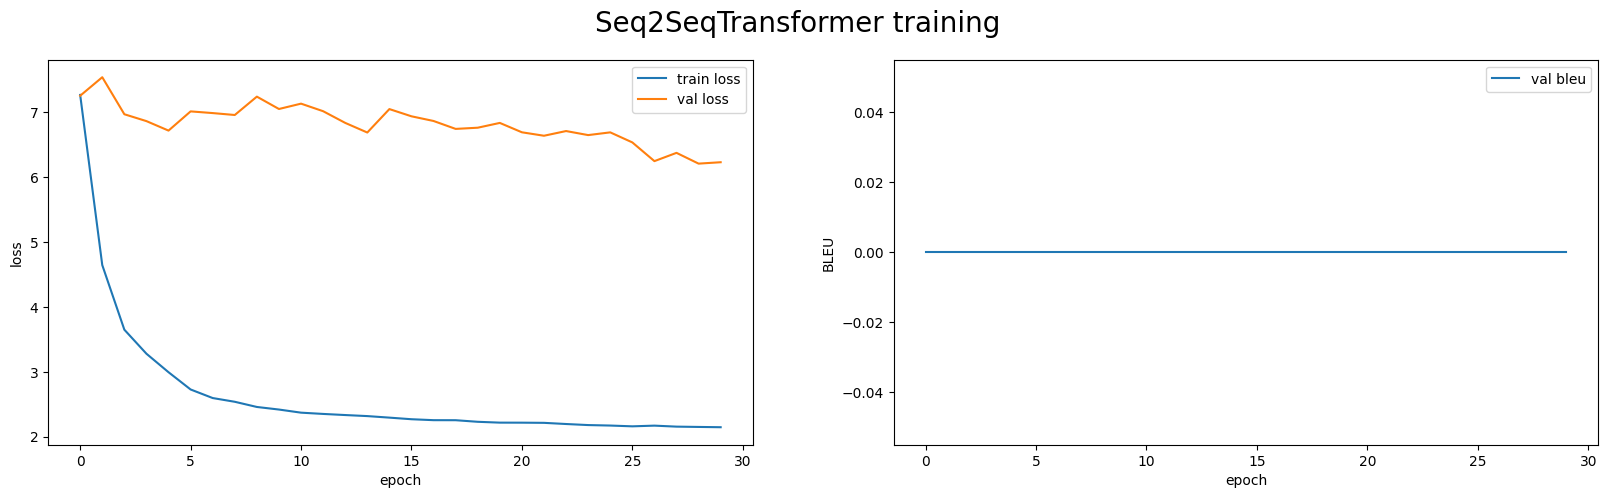

In [ ]:
import matplotlib.pylab as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(range(len(train_loss_list)), train_loss_list, label='train loss')
ax1.plot(range(len(val_loss_list)), val_loss_list, label='val loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(range(len(val_bleu_list)), val_bleu_list, label='val bleu')
ax2.set_xlabel('epoch')
ax2.set_ylabel('BLEU')
ax2.legend()

fig.suptitle('Seq2SeqTransformer training', fontsize=20)
plt.show()

### Fine-tune pretrained T5 (25 баллов)

Реализуйте Seq2seq Pretrained T5. Воспользуйтесь https://huggingface.co/docs/transformers/model_doc/t5 предобученной моделью. В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Не забудьте важные аспекты обучения модели:
* Взять готовый t5 токенизатор
* Resize matrix embedding - скорей всего ваша матрица эмбеддингов не будет включать эмбеддинги из вашего сета. Пример обновления матрицы эмбеддингов тут тут https://github.com/runnerup96/Transformers-Tuning/blob/main/t5_encoder_decoder.py
* Learning rate schedualer/Adafactor with constant learning rate


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, pretrained model name
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [ ]:
# CODE HERE